# Electrode Expansion
Plot expansion for UM battery lab pouch cell parameters

In [20]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.integrate import solve_ivp

In [210]:
def nmc_volume_change_mohtat(sto):
    t_change = -1.10/100*(1-sto)
    return t_change
    
def graphite_volume_change_mohtat(sto):
    a = 0.50
    b = 0.24
    c = 0.18 
    d = 0.12
    t_change = (
        (0 <= sto and sto < d)*(2.4060/d*sto)+
        (d <= sto and sto < c)*(-(2.4060-3.3568)/(c-d)*(sto-d)+2.4060)+
        (c <= sto and sto < b)*(-(3.3568-4.3668)/(b-c)*(sto-c)+3.3568)+
        (b <= sto and sto < a)*(-(4.3668-5.5830)/(a-b)*(sto-b)+4.3668)+
        (a <= sto and sto <= 1)*(-(5.583-13.0635)/(1-a)*(sto-a)+5.583)
    )
    # t_change = (
    #     (0 <= sto and sto <= a)*(-(-5.5830)/(a)*(sto))+
    #     (a <= sto and sto <= 1)*(-(5.583-13.0635)/(1-a)*(sto-a)+5.583)
    # )
    t_change = t_change/100
    return t_change

def get_parameter_values():
    parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
    parameter_values.update(
        {
            # mechanical properties
            "Positive electrode Poisson's ratio": 0.3,
            "Positive electrode Young's modulus [Pa]": 375e9,
            "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
            "Positive electrode volume change": nmc_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Positive electrode LAM constant exponential term": 2,
            "Positive electrode critical stress [Pa]": 375e6,
            # mechanical properties
            "Negative electrode Poisson's ratio": 0.2,
            "Negative electrode Young's modulus [Pa]": 15e9,
            "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
            "Negative electrode volume change": graphite_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode critical stress [Pa]": 60e6,
            # Other
            "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
            "Lower voltage cut-off [V]": 3.0
        },
        check_already_exists=False,
    )
    return parameter_values
parameter_values = get_parameter_values()

In [211]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
c_rate_c = 'C/5'
c_rate_d = 'C/5'
dis_set = " until 3V"
experiment = pybamm.Experiment(
    [
        "Discharge at "+c_rate_d+dis_set,
        "Rest for 5 min",
        "Charge at "+c_rate_c+" until 4.2V", 
        "Hold at 4.2V until C/50"
    ],
)
spm = pybamm.lithium_ion.SPM(
    {
        "particle mechanics": "swelling only",
    }
)

In [212]:
sol = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol = sol.solve(initial_soc=1)

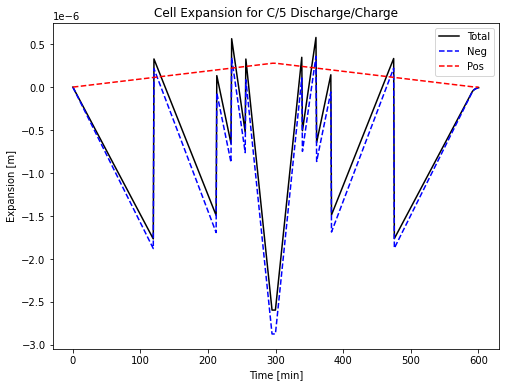

In [213]:
t = sol["Time [min]"].entries
cell_thickness = sol["Cell thickness change [m]"].entries
cell_thickness_n = sol["Negative Electrode thickness change [m]"].entries
cell_thickness_p = sol["Positive Electrode thickness change [m]"].entries
plt.figure(figsize=(8, 6))
plt.plot(t,cell_thickness,'k')
plt.plot(t,cell_thickness_n,'b--')
plt.plot(t,cell_thickness_p,'r--')
plt.legend(['Total' , 'Neg'  , 'Pos'])
plt.xlabel('Time [min]')
plt.ylabel('Expansion [m]')
plt.title('Cell Expansion for C/5 Discharge/Charge');
plt.savefig('exp plot.png',dpi=300)

In [214]:
# quick_plot =pybamm.QuickPlot(sol, figsize=(14,7),output_variables=
# ['Positive particle surface concentration [mol.m-3]','R-averaged positive particle concentration [mol.m-3]'])
# quick_plot.dynamic_plot();

In [215]:
# spm.variable_names()

In [216]:
spm.variables.search("positive particle concentration")

Average positive particle concentration
Average positive particle concentration [mol.m-3]
Maximum positive particle concentration
Maximum positive particle concentration [mol.m-3]
Minimum positive particle concentration
Minimum positive particle concentration [mol.m-3]
Positive particle concentration
Positive particle concentration [mol.m-3]
R-averaged positive particle concentration
R-averaged positive particle concentration [mol.m-3]
X-averaged positive particle concentration
X-averaged positive particle concentration [mol.m-3]


In [217]:
parameter_values.search("parallel")

Number of electrodes connected in parallel to make a cell	1.0


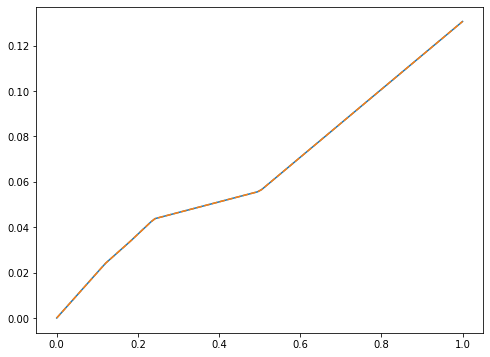

In [218]:
def graphite_volume_change(sto):
    a = 0.50
    b = 0.24
    c = 0.18 
    d = 0.12
    t_change = 0
    if sto < d:
        t_change = 2.4060/d*sto
    elif d <= sto and sto < c:
        t_change = -(2.4060-3.3568)/(c-d)*(sto-d)+2.4060
    elif c <= sto and sto < b:
        t_change = -(3.3568-4.3668)/(b-c)*(sto-c)+3.3568
    elif b <= sto and sto < a:
        t_change = -(4.3668-5.583)/(a-b)*(sto-b)+4.3668
    elif a <= sto:
        t_change = -(5.583-13.0635)/(1-a)*(sto-a)+5.583
    t_change = t_change/100
    return t_change
sto = np.linspace(0,1,100)
yout = np.zeros(len(sto))
yout1 = np.zeros(len(sto))
for i in range(len(sto)):
    yout[i] = graphite_volume_change(sto[i])
    yout1[i] = graphite_volume_change_mohtat(sto[i])
plt.figure(figsize=(8, 6))
plt.plot(sto,yout)
plt.plot(sto,yout1,'--')
